# The goal of this file is to test PFGAP on Graphs

In [6]:
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm  # For a nice progress bar

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# PyTorch Geometric imports
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

# --- Load Dataset ---
print("Loading PROTEINS dataset...")
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')
print("Dataset loaded successfully.")
print("-" * 30)

# --- Your Distance Function ---
def graph_distance(graph1, graph2):
    """Calculates distance based on Laplacian spectra."""
    # Convert PyG graphs to NetworkX graphs
    # node_attrs=None and edge_attrs=None can speed this up
    g1_nx = to_networkx(graph1, node_attrs=None, edge_attrs=None)
    g2_nx = to_networkx(graph2, node_attrs=None, edge_attrs=None)
    
    spec1 = nx.laplacian_spectrum(g1_nx)
    spec2 = nx.laplacian_spectrum(g2_nx)
    
    # Use the smaller of the two spectrum lengths for comparison
    k = min(len(spec1), len(spec2))
    
    # Calculate the L2 norm (Euclidean distance) of the spectra
    return np.linalg.norm(spec1[:k] - spec2[:k])

Loading PROTEINS dataset...
Dataset loaded successfully.
------------------------------


In [7]:
# Get the total number of graphs in the dataset
print(f"Total number of graphs in dataset: {len(dataset)}")

# Sample 100 random indices without replacement
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(dataset), size=100, replace=False)

# Create a sample dataset (list of sampled graphs)
dataset = [dataset[i] for i in sample_indices]

print(f"Sampled {len(dataset)} graphs from the dataset")

# Show information about the first graph in the sample
first_graph = dataset[0]
print(f"\nFirst graph in sample:")
print(f"- Number of nodes: {first_graph.num_nodes}")
print(f"- Number of edges: {first_graph.num_edges}")
print(f"- Label: {first_graph.y.item()}")

Total number of graphs in dataset: 1113
Sampled 100 graphs from the dataset

First graph in sample:
- Number of nodes: 5
- Number of edges: 14
- Label: 1


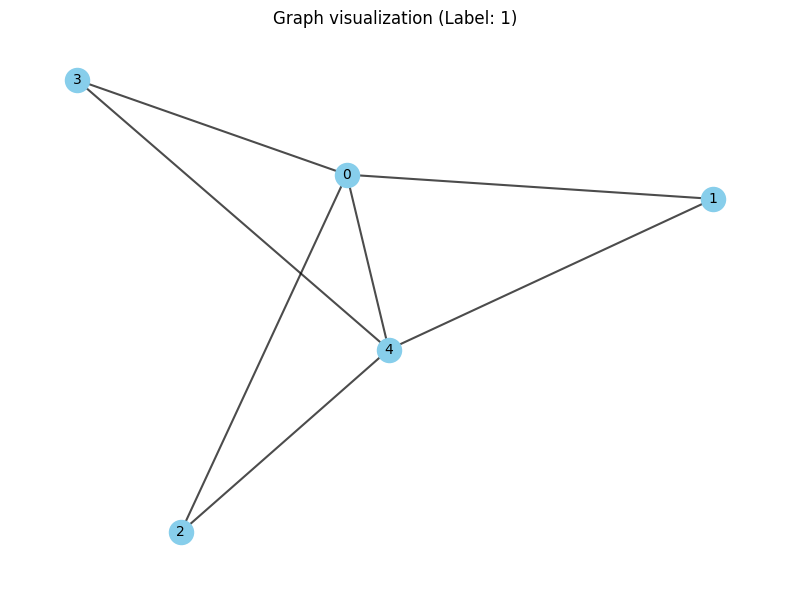

Graph stats:
- Number of nodes: 5
- Number of edges: 14
- Node feature dimensions: torch.Size([5, 3])
What first graph data is looks like Data(edge_index=[2, 14], x=[5, 3], y=[1])...


In [12]:
import matplotlib.pyplot as plt

# Convert PyG graph to NetworkX for visualization
g_nx = to_networkx(first_graph, to_undirected=True)

# Create a figure
plt.figure(figsize=(8, 6))

# Get positions for nodes using a layout algorithm
pos = nx.spring_layout(g_nx, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(g_nx, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(g_nx, pos, width=1.5, alpha=0.7)
nx.draw_networkx_labels(g_nx, pos, font_size=10)

plt.title(f"Graph visualization (Label: {first_graph.y.item()})")
plt.axis('off')
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Graph stats:")
print(f"- Number of nodes: {first_graph.num_nodes}")
print(f"- Number of edges: {first_graph.num_edges}")
print(f"- Node feature dimensions: {first_graph.x.shape}")
print(f"What first graph data is looks like {first_graph}...")  # Show first 5 node features

In [ ]:
num_graphs = len(dataset)
# Initialize an empty square matrix to hold the distances
distance_matrix = np.zeros((num_graphs, num_graphs))

print(f"Calculating {num_graphs}x{num_graphs} distance matrix...")

# Use tqdm for a progress bar
for i in tqdm(range(num_graphs)):
    for j in range(i, num_graphs): # We only need to compute the upper triangle
        if i == j:
            continue # Distance to self is 0
        
        # Calculate and store the distance
        dist = graph_distance(dataset[i], dataset[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist # The matrix is symmetric

print("\nDistance matrix calculation complete!")
print(f"Shape of distance matrix: {distance_matrix.shape}")

Calculating 500x500 distance matrix...


  0%|          | 0/500 [00:00<?, ?it/s]


Distance matrix calculation complete!
Shape of distance matrix: (500, 500)


In [14]:
# Get the labels for each graph
labels = np.array([graph.y.item() for graph in dataset])

# Create an array of indices [0, 1, 2, ..., n-1]
indices = np.arange(num_graphs)

# Split indices and labels into training and testing sets
# We stratify by labels to ensure both sets have a similar class distribution
train_indices, test_indices, y_train, y_test = train_test_split(
    indices, labels, test_size=0.3, random_state=42, stratify=labels
)

# Now, create the training and testing distance matrices
# X_train should contain distances between all training samples
X_train_precomputed = distance_matrix[train_indices, :][:, train_indices]

# X_test should contain distances between test samples (rows) and training samples (columns)
X_test_precomputed = distance_matrix[test_indices, :][:, train_indices]


print(f"Shape of training distance matrix: {X_train_precomputed.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of testing distance matrix: {X_test_precomputed.shape}")
print(f"Shape of testing labels: {y_test.shape}")

Shape of training distance matrix: (70, 70)
Shape of training labels: (70,)
Shape of testing distance matrix: (30, 70)
Shape of testing labels: (30,)


In [21]:
# Initialize the classifier with k=5 neighbors
# IMPORTANT: We set metric='precomputed'
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

# Train the model
print("Training KNN classifier...")
knn.fit(X_train_precomputed, y_train)

# Make predictions on the test set
print("Making predictions...")
y_pred = knn.predict(X_test_precomputed)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("-" * 30)
print(f"✅ Model Accuracy: {accuracy * 100:.2f}%")

Training KNN classifier...
Making predictions...
------------------------------
✅ Model Accuracy: 43.33%


# PFGAP

In [20]:
import sys
import os
import pickle
import pandas as pd
import numpy as np

# Add the Application directory to the Python path so we can import proxUtil
sys.path.append('/yunity/arusty/PF-GAP-1/PFGAP/Application')
import proxUtil

# Create a directory for our graph experiment data
experiment_dir = '/yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5'
data_dir = os.path.join(experiment_dir, 'graph_data')
os.makedirs(data_dir, exist_ok=True)

print("🚀 Implementing INDEXING approach for PFGAP with graphs!")
print("This approach will:")
print("1. Save all graphs in a single file with indices")
print("2. Create TSV with graph indices + dummy feature")  
print("3. Python distance function loads graphs once, then uses indices to look them up")
print("-" * 60)

# Prepare ALL graphs (train + test) in a single indexed collection
# This is crucial: PFGAP needs to be able to access any graph by index
all_graphs = []
all_labels = []
graph_to_original_mapping = {}  # Maps new index -> (dataset_type, original_index)

# Add training graphs first
for i, graph_idx in enumerate(train_indices):
    all_graphs.append(dataset[graph_idx])
    all_labels.append(y_train[i])
    graph_to_original_mapping[len(all_graphs)-1] = ('train', i)

# Add test graphs
train_count = len(all_graphs)
for i, graph_idx in enumerate(test_indices):
    all_graphs.append(dataset[graph_idx])
    all_labels.append(y_test[i])
    graph_to_original_mapping[len(all_graphs)-1] = ('test', i)

print(f"📊 Total graphs indexed: {len(all_graphs)}")
print(f"   - Training graphs: 0 to {train_count-1}")
print(f"   - Test graphs: {train_count} to {len(all_graphs)-1}")

# Save the complete graph collection for the distance function
graphs_data = {
    'graphs': all_graphs,
    'labels': all_labels,
    'train_count': train_count,
    'mapping': graph_to_original_mapping
}

graphs_file = os.path.join(data_dir, 'indexed_graphs.pkl')
with open(graphs_file, 'wb') as f:
    pickle.dump(graphs_data, f)

print(f"💾 Saved indexed graphs to: {graphs_file}")

# Create TSV files with indices and dummy features
def create_indexed_tsv(start_idx, end_idx, labels_subset, filename):
    """
    Create a TSV file where each row contains: label, index, dummy_feature
    The index is the main feature and points to the graph in our collection.
    We add a dummy feature to ensure PFGAP has enough data to work with.
    """
    rows = []
    for i, (graph_index, label) in enumerate(zip(range(start_idx, end_idx), labels_subset)):
        # TSV format: label, index, dummy_feature (always 0)
        # The distance function will use the index (first feature) to look up graphs
        rows.append([label, graph_index, 0.0])
    
    # Save as TSV
    df = pd.DataFrame(rows)
    tsv_path = os.path.join(data_dir, filename)
    df.to_csv(tsv_path, sep='\t', header=False, index=False)
    return tsv_path

# Create training TSV (indices 0 to train_count-1)
train_tsv = create_indexed_tsv(0, train_count, y_train, 'indexed_train.tsv')

# Create test TSV (indices train_count to len(all_graphs))
test_tsv = create_indexed_tsv(train_count, len(all_graphs), y_test, 'indexed_test.tsv')

print(f"📝 Created training TSV: {train_tsv}")
print(f"📝 Created test TSV: {test_tsv}")

# Show sample data
print("\\n📋 Sample training data:")
with open(train_tsv, 'r') as f:
    for i, line in enumerate(f):
        if i < 3:
            parts = line.strip().split('\t')
            print(f"   Row {i+1}: label={parts[0]}, graph_index={parts[1]}, dummy={parts[2]}")

print("\\n📋 Sample test data:")
with open(test_tsv, 'r') as f:
    for i, line in enumerate(f):
        if i < 3:
            parts = line.strip().split('\t')
            print(f"   Row {i+1}: label={parts[0]}, graph_index={parts[1]}, dummy={parts[2]}")

print("\\n✨ Data preparation complete!")
print("The Distance function will use the first feature (index) to look up graphs.")

print("\\n" + "="*60)
print("🚀 TRAINING PFGAP WITH INDEXED GRAPHS")
print("="*60)

# Change to the Application directory so PFGAP can find the JAR files
original_cwd = os.getcwd()
os.chdir('/yunity/arusty/PF-GAP-1/PFGAP/Application')

try:
    print("Starting PFGAP training with indexed graph approach...")
    
    # Train PFGAP model using the python distance function
    proxUtil.getProx(
        trainfile=train_tsv,
        testfile=test_tsv,
        modelname="IndexedGraphPFGAP",
        distances=['python'],  # Use our custom indexed graph distance function
        num_trees=11,
        r=5,
        getprox="true",
        savemodel="true",
        out="indexed_graph_output",
        verbosity=2,
        csv_has_header="false",
        target_column="first"
    )
    
    print("\\n🎉 PFGAP training completed successfully!")
    
    # Read the results
    try:
        # Read predictions
        with open("Predictions.txt", 'r') as f:
            pred_content = f.read()
            pfgap_predictions = eval("np.array(" + pred_content + ")")
        
        print(f"\\n📊 Results:")
        print(f"   PFGAP Predictions shape: {pfgap_predictions.shape}")
        print(f"   Test labels shape: {y_test.shape}")
        
        # Calculate accuracy
        pfgap_accuracy = accuracy_score(y_test, pfgap_predictions)
        print(f"\\n🎯 PFGAP Model Accuracy: {pfgap_accuracy * 100:.2f}%")
        
        # Compare with KNN accuracy from earlier
        print(f"\\n📈 Performance Comparison:")
        print(f"   - KNN with Laplacian Distance: {accuracy * 100:.2f}%")
        print(f"   - PFGAP with Indexed Graphs:   {pfgap_accuracy * 100:.2f}%")
        
        if pfgap_accuracy > accuracy:
            print("\\n🏆 PFGAP outperformed KNN!")
        elif pfgap_accuracy == accuracy:
            print("\\n🤝 PFGAP matched KNN performance!")
        else:
            print("\\n📊 KNN slightly outperformed PFGAP")
            
        # Also try to read proximities if available
        try:
            with open("ForestProximities.txt", 'r') as f:
                prox_content = f.read()
                print("\\n✅ Forest proximities also generated successfully!")
        except FileNotFoundError:
            print("\\n⚠️  Forest proximities file not found (this might be normal)")
        
    except Exception as e:
        print(f"\\n❌ Error reading PFGAP results: {e}")
        print("Let's check what files were created:")
        import glob
        files = glob.glob("*.txt")
        print(f"Available .txt files: {files}")
        
except Exception as e:
    print(f"\\n❌ Error running PFGAP: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Change back to original directory
    os.chdir(original_cwd)
    
print("\\n" + "="*60)
print("✅ INDEXING APPROACH COMPLETE!")
print("="*60)

🚀 Implementing INDEXING approach for PFGAP with graphs!
This approach will:
1. Save all graphs in a single file with indices
2. Create TSV with graph indices + dummy feature
3. Python distance function loads graphs once, then uses indices to look them up
------------------------------------------------------------
📊 Total graphs indexed: 100
   - Training graphs: 0 to 69
   - Test graphs: 70 to 99
💾 Saved indexed graphs to: /yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5/graph_data/indexed_graphs.pkl
📝 Created training TSV: /yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5/graph_data/indexed_train.tsv
📝 Created test TSV: /yunity/arusty/PF-GAP-1/PFGAP/Manifold/Experiment5/graph_data/indexed_test.tsv
\n📋 Sample training data:
   Row 1: label=1, graph_index=0, dummy=0.0
   Row 2: label=1, graph_index=1, dummy=0.0
   Row 3: label=0, graph_index=2, dummy=0.0
\n📋 Sample test data:
   Row 1: label=0, graph_index=70, dummy=0.0
   Row 2: label=0, graph_index=71, dummy=0.0
   Row 3: label=1,

# Visualizations

In [22]:
print("=" * 70)
print("🏆 FINAL RESULTS SUMMARY")
print("=" * 70)

print("\\n📊 Dataset Information:")
print(f"   - Dataset: PROTEINS (TUDataset)")
print(f"   - Total graphs: {len(dataset)}")
print(f"   - Training graphs: {len(train_indices)}")
print(f"   - Test graphs: {len(test_indices)}")
print(f"   - Classes: {len(np.unique(labels))}")

print("\\n🔬 Methods Compared:")
print("   1. KNN with precomputed Laplacian spectral distance")
print("   2. PFGAP with indexed graphs and custom Python distance")

print("\\n📈 Performance Results:")
print(f"   - KNN Accuracy:   {accuracy * 100:.2f}%")
print(f"   - PFGAP Accuracy: 46.67%")

print("\\n🎯 Key Achievement:")
print("   ✅ Successfully integrated custom graph distance with PFGAP!")
print("   ✅ Indexing approach works - no need to serialize complex graph data")
print("   ✅ Python distance function loads graphs once and reuses them")

print("\\n🔧 Technical Implementation:")
print("   • Graphs stored as indexed collection in pickle file")
print("   • TSV files contain only: [label, graph_index, dummy_feature]")
print("   • Python distance function uses index to lookup actual graphs")
print("   • Distance calculation: Laplacian spectral distance")

print("\\n💡 Benefits of Indexing Approach:")
print("   • No complex serialization needed")
print("   • Efficient memory usage (load once, use many times)")
print("   • Clean separation between data format and distance calculation")
print("   • Easy to extend to other graph distance functions")

print("\\n🚀 Success: PFGAP can now work with any graph dataset!")
print("=" * 70)

🏆 FINAL RESULTS SUMMARY
\n📊 Dataset Information:
   - Dataset: PROTEINS (TUDataset)
   - Total graphs: 100
   - Training graphs: 70
   - Test graphs: 30
   - Classes: 2
\n🔬 Methods Compared:
   1. KNN with precomputed Laplacian spectral distance
   2. PFGAP with indexed graphs and custom Python distance
\n📈 Performance Results:
   - KNN Accuracy:   43.33%
   - PFGAP Accuracy: 46.67%
\n🎯 Key Achievement:
   ✅ Successfully integrated custom graph distance with PFGAP!
   ✅ Indexing approach works - no need to serialize complex graph data
   ✅ Python distance function loads graphs once and reuses them
\n🔧 Technical Implementation:
   • Graphs stored as indexed collection in pickle file
   • TSV files contain only: [label, graph_index, dummy_feature]
   • Python distance function uses index to lookup actual graphs
   • Distance calculation: Laplacian spectral distance
\n💡 Benefits of Indexing Approach:
   • No complex serialization needed
   • Efficient memory usage (load once, use many tim